# Problem statement: 
* The data has 45,429 rows and 19 variables.
* Dataset is slightly imbalanced: 23349 alive vs. 22080 dead infants at report. 
* This is a binary classification problem. The classification goal is to predict wheter or not the infant dies at birth.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
    
 # Model Training: 
- I separately train following models:
     - Logistic Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model. 

  # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - roc_auc score
     - f1 score
     - Confusion matrix
     - ROC curve  
     - Average precision
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark

import sklearn
import numpy as np
from scipy import stats
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]")\
                            .appName("Infant_Birth")\
                            .enableHiveSupport()\
                            .getOrCreate()

#spark.conf.set('spark.driver.memory','8g')
#spark.conf.set('spark.executor.memory', '8g')
#spark.conf.set('spark.executor.cores', '6')
#spark.conf.set('spark.cores.max', '6')

sc = spark.sparkContext

In [3]:
sc.getConf().getAll()

[('spark.app.id', 'local-1534972000162'),
 ('spark.rdd.compress', 'True'),
 ('hive.metastore.warehouse.dir',
  'file:/home/rhashemee/Documents/Spark%20projects/Infant%20Birth/spark-warehouse'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.name', 'Infant_Birth'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '44649'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '10.0.2.15')]

In [4]:
# To create a new configuration and use that to create a SparkContext.
#conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','8g')])
#sc.stop()
#sc = pyspark.SparkContext(conf=conf)

In [5]:
# Approach 1: We import dataset directly as a Data Frame
df=spark.read.csv('births_train.csv.gz', header=True, inferSchema=True)

In [6]:
df = df.repartition(4)

In [7]:
df.rdd.getNumPartitions()

4

In [8]:
# We drop all of the features that relate to the infant: Keep the most important ones
selected_features = [
    'INFANT_ALIVE_AT_REPORT', 
    'BIRTH_PLACE', 
    'MOTHER_AGE_YEARS', 
    'FATHER_COMBINED_AGE', 
    'CIG_BEFORE', 
    'CIG_1_TRI', 
    'CIG_2_TRI', 
    'CIG_3_TRI', 
    'MOTHER_HEIGHT_IN', 
    'MOTHER_PRE_WEIGHT', 
    'MOTHER_DELIVERY_WEIGHT', 
    'MOTHER_WEIGHT_GAIN', 
    'DIABETES_PRE', 
    'DIABETES_GEST', 
    'HYP_TENS_PRE', 
    'HYP_TENS_GEST', 
    'PREV_BIRTH_PRETERM']

df = df.select(selected_features)
df.printSchema()

root
 |-- INFANT_ALIVE_AT_REPORT: string (nullable = true)
 |-- BIRTH_PLACE: integer (nullable = true)
 |-- MOTHER_AGE_YEARS: integer (nullable = true)
 |-- FATHER_COMBINED_AGE: integer (nullable = true)
 |-- CIG_BEFORE: integer (nullable = true)
 |-- CIG_1_TRI: integer (nullable = true)
 |-- CIG_2_TRI: integer (nullable = true)
 |-- CIG_3_TRI: integer (nullable = true)
 |-- MOTHER_HEIGHT_IN: integer (nullable = true)
 |-- MOTHER_PRE_WEIGHT: integer (nullable = true)
 |-- MOTHER_DELIVERY_WEIGHT: integer (nullable = true)
 |-- MOTHER_WEIGHT_GAIN: integer (nullable = true)
 |-- DIABETES_PRE: string (nullable = true)
 |-- DIABETES_GEST: string (nullable = true)
 |-- HYP_TENS_PRE: string (nullable = true)
 |-- HYP_TENS_GEST: string (nullable = true)
 |-- PREV_BIRTH_PRETERM: string (nullable = true)



In [9]:
df.count()

45429

In [10]:
for c in selected_features:
    df.groupBy(c).count().show()

+----------------------+-----+
|INFANT_ALIVE_AT_REPORT|count|
+----------------------+-----+
|                     Y|23349|
|                     N|22080|
+----------------------+-----+

+-----------+-----+
|BIRTH_PLACE|count|
+-----------+-----+
|          1|44558|
|          6|   11|
|          3|  224|
|          5|   74|
|          9|    8|
|          4|  327|
|          7|   91|
|          2|  136|
+-----------+-----+

+----------------+-----+
|MOTHER_AGE_YEARS|count|
+----------------+-----+
|              31| 2471|
|              34| 1925|
|              28| 2669|
|              27| 2594|
|              26| 2617|
|              44|  104|
|              12|    2|
|              22| 2212|
|              47|   20|
|              13|    8|
|              16|  281|
|              20| 1712|
|              40|  533|
|              48|    8|
|              19| 1318|
|              41|  407|
|              43|  204|
|              15|  126|
|              37| 1120|
|              17|  49

In [11]:
# Correct the features related to the number of smoked cigarettes:
from pyspark.sql.functions import when
for c in ['CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI']:
       df = df.withColumn(c, when(df[c] == 99, 0)\
                             .otherwise(df[c]))

In [12]:
# helpful function to detect the Missing Values:
def detect_missing(df):
    import pyspark.sql.functions as fn
    miss_count=df.agg(*[(fn.count('*')-fn.count(c)).alias(c)   for c in df.columns]).toPandas()
    miss_percent=df.agg(*[(1-(fn.count(c)/fn.count('*'))).alias(c)   for c in df.columns]).toPandas()
    
    summary = pd.concat([miss_count, miss_percent], axis=0)
    summary['  '] = ['Count of miss values: ', 'Percentage of miss values: ']
    summary.set_index('  ', inplace=True)
    return summary

# helpful function to detect the Duplicate Values:
def detect_duplicates(df):
    print('Count of rows: ', df.count())
    print('Count of distinct rows: ', df.distinct().count())

In [13]:
# Check for Missing values:
detect_missing(df)

,INFANT_ALIVE_AT_REPORT,BIRTH_PLACE,MOTHER_AGE_YEARS,FATHER_COMBINED_AGE,CIG_BEFORE,CIG_1_TRI,CIG_2_TRI,CIG_3_TRI,MOTHER_HEIGHT_IN,MOTHER_PRE_WEIGHT,MOTHER_DELIVERY_WEIGHT,MOTHER_WEIGHT_GAIN,DIABETES_PRE,DIABETES_GEST,HYP_TENS_PRE,HYP_TENS_GEST,PREV_BIRTH_PRETERM
,,,,,,,,,,,,,,,,,
Count of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Check for Duplicates: 
detect_duplicates(df)

#df.dropDuplicates() # Drop duplicate values

Count of rows:  45429
Count of distinct rows:  43826


In [15]:
# Dataset is almost balanced:
df.groupBy('INFANT_ALIVE_AT_REPORT').count().show()

+----------------------+-----+
|INFANT_ALIVE_AT_REPORT|count|
+----------------------+-----+
|                     Y|23349|
|                     N|22080|
+----------------------+-----+



# Preparing Data for Machine Learning:

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = ['BIRTH_PLACE', 'DIABETES_PRE', 'DIABETES_GEST', 
                      'HYP_TENS_PRE', 'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM']   # specify nominal categorical features
ordinalColumns = [ ]     # specify ordinal categorical features


stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]

    
label_stringIdx = StringIndexer(inputCol = 'INFANT_ALIVE_AT_REPORT', outputCol = 'label')
stages += [label_stringIdx]    
    
# Continuous features: 
numericCols = ['MOTHER_AGE_YEARS', 'FATHER_COMBINED_AGE', 'CIG_BEFORE', 'CIG_1_TRI',
               'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT',
               'MOTHER_WEIGHT_GAIN']


# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns]+ numericCols
        
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [17]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_piped = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- INFANT_ALIVE_AT_REPORT: string (nullable = true)
 |-- BIRTH_PLACE: integer (nullable = true)
 |-- MOTHER_AGE_YEARS: integer (nullable = true)
 |-- FATHER_COMBINED_AGE: integer (nullable = true)
 |-- CIG_BEFORE: integer (nullable = true)
 |-- CIG_1_TRI: integer (nullable = true)
 |-- CIG_2_TRI: integer (nullable = true)
 |-- CIG_3_TRI: integer (nullable = true)
 |-- MOTHER_HEIGHT_IN: integer (nullable = true)
 |-- MOTHER_PRE_WEIGHT: integer (nullable = true)
 |-- MOTHER_DELIVERY_WEIGHT: integer (nullable = true)
 |-- MOTHER_WEIGHT_GAIN: integer (nullable = true)
 |-- DIABETES_PRE: string (nullable = true)
 |-- DIABETES_GEST: string (nullable = true)
 |-- HYP_TENS_PRE: string (nullable = true)
 |-- HYP_TENS_GEST: string (nullable = true)
 |-- PREV_BIRTH_PRETERM: string (nullable = true)



In [18]:
train, test = df_piped.randomSplit([0.75, 0.25], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 34119
Test Dataset Count: 11310


# Algorithm 1:   Logistic Regression

In [19]:
# To calculate the Calss Weight for Logestic Regression:
new_train=train.join(train.groupBy('label').count(), 'label', how='leftouter')
train_weight=new_train.withColumn('weight', train.count()/(new_train['count']))

train_weight.groupBy('weight').count().show()

+------------------+-----+
|            weight|count|
+------------------+-----+
|2.0618201595358956|16548|
| 1.941779067782141|17571|
+------------------+-----+



In [20]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, 
                         weightCol ='weight')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(lr.regParam, [0, 0.01, 0.1])
grid=grid.addGrid(lr.elasticNetParam, [0, 1])
grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=lr,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=2,
                         seed=42)

In [21]:
# fit the model:
models=cv.fit(train_weight)
best_lr=models.bestModel

# Best hyper-parameters: 
java_model = best_lr._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'regParam': 0.0, 'elasticNetParam': 1.0}
Best cross-validation score:   0.74


In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
print('Test roc_auc score: ', round(best_lr.evaluate(test).areaUnderROC,2), '\n')

print('Test average precision: ', round(evaluator.evaluate(best_lr.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Test f1 score: ', round(my_eval.evaluate(best_lr.transform(test)),2))

Test roc_auc score:  0.74 

Test average precision:  0.72 

Test f1 score:  0.69


In [23]:
# Prediction on test dataset:
test_predictions = best_lr.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[-1.3203529760877...|[0.21075957344950...|       1.0|
|  0.0|[-1.4795825576186...|[0.18549047977814...|       1.0|
|  0.0|[-0.5435162682837...|[0.36736998843080...|       1.0|
|  0.0|[-1.5329733861023...|[0.17755906036817...|       1.0|
|  0.0|[1.05268724630763...|[0.74129059025902...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[4152 1626]
 [1861 3671]]
Normalized confusion matrix
[[0.72 0.28]
 [0.34 0.66]]


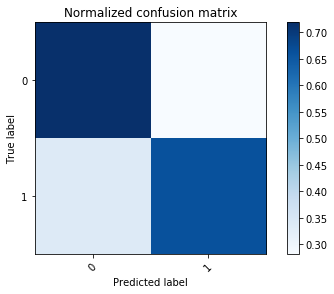

In [24]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

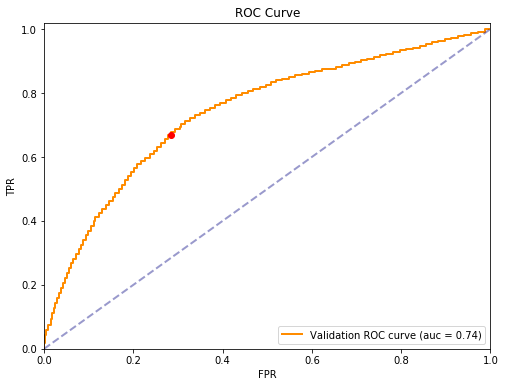

In [25]:
# ROC curve:______________________________________
validation_accuracy=best_lr.evaluate(test)
roc=validation_accuracy.roc.toPandas()
roc_auc=validation_accuracy.areaUnderROC

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(roc['FPR'],roc['TPR'], color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")

recall=validation_accuracy.recallByThreshold.toPandas()
recall=recall[np.round(recall['threshold'], 2)==0.5]['recall']
roc=validation_accuracy.roc.toPandas().iloc[recall.index[0]+1]
plt.plot(roc[0], roc[1], 'or')

plt.show()

# Algorithm 2: Random Forest

In [26]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(rf.maxDepth, [15, 30])
grid=grid.addGrid(rf.numTrees, [50])
grid=grid.addGrid(rf.maxBins, [32, 64])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=rf,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=2,
                         seed=42)

In [27]:
# fit the model:
models=cv.fit(train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'numTrees': 50, 'maxBins': 64, 'maxDepth': 15}
Best cross-validation score:   0.78


In [28]:
my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Test roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

print('Test average precision: ', round(evaluator.evaluate(best_rf.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Test f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Test roc_auc score:  0.79 

Test average precision:  0.78 

Test f1 score:  0.73


In [29]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[8.93147968359194...|[0.17862959367183...|       1.0|
|  0.0|[13.6859585657017...|[0.27371917131403...|       1.0|
|  0.0|[16.0897290518683...|[0.32179458103736...|       1.0|
|  0.0|[16.7176677023078...|[0.33435335404615...|       1.0|
|  0.0|[35.1884646605082...|[0.70376929321016...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[4408 1370]
 [1712 3820]]
Normalized confusion matrix
[[0.76 0.24]
 [0.31 0.69]]


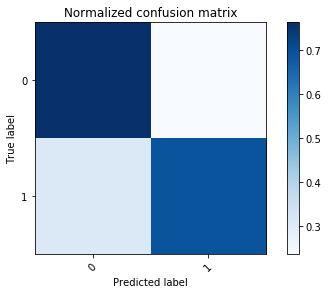

In [30]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

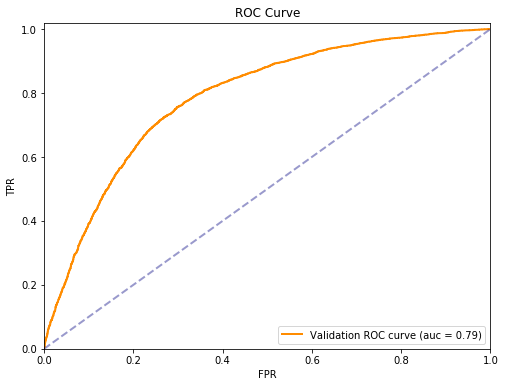

In [31]:
# ROC curve:______________________________________
prediction = best_rf.transform(test)
results= prediction.select(['probability', 'label']).collect()
results = [(i[0][0], 1.0-i[1]) for i in results]

from sklearn.metrics import roc_curve, auc
 
fpr= dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results]
y_score = [i[0] for i in results]
 
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(fpr, tpr, color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")


plt.show()

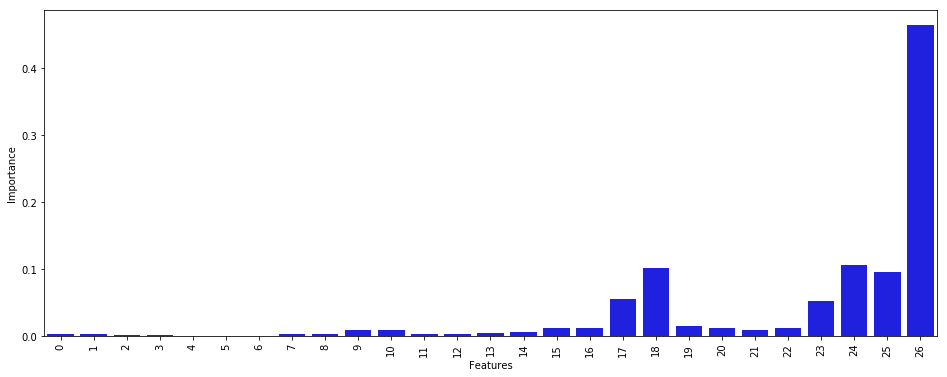

In [32]:
# Feature Importance: 
im=best_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=90)
plt.show()

# Algorithm 3: Gradient Boosted Trees

In [33]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.MulticlassClassificationEvaluator(metricName='f1')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(gb.maxDepth, [4, 6])
grid=grid.addGrid(gb.maxIter, [64])
grid=grid.addGrid(gb.maxBins, [16, 48])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=gb,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=2,
                         seed=42)

In [34]:
# fit the model:
models=cv.fit(train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})
print("Best cross-validation score:  ", round(max(models.avgMetrics), 2)) 

Best hyper-parameters:  {'maxBins': 16, 'maxDepth': 4, 'maxIter': 64}
Best cross-validation score:   0.72


In [35]:
print("Test f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Test f1 score:   0.73


In [36]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[4489 1289]
 [1793 3739]]
Normalized confusion matrix
[[0.78 0.22]
 [0.32 0.68]]


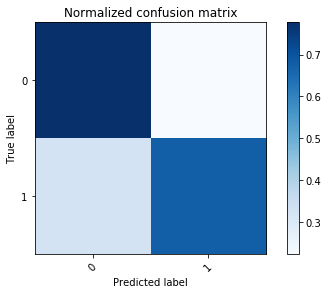

In [37]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

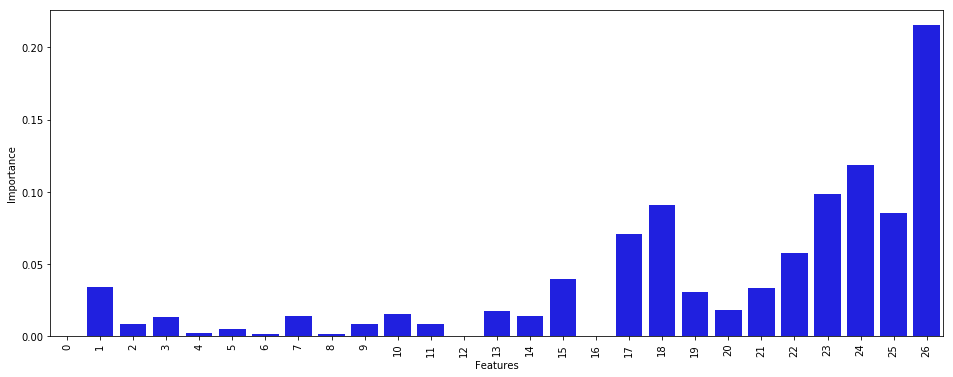

In [38]:
# Feature Importance: 
im=best_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=90)

plt.show()

In [39]:
sc.stop()